In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:

filtered_data = pd.read_csv(r"C:\Users\Admin\Downloads\Reviews.csv\Reviews.csv")
def partition(x):
    if x < 3:
        return 0
    return 1


In [3]:
df = pd.read_csv(r"C:\Users\Admin\Downloads\Reviews.csv\Reviews.csv")
np.random.seed(50)
df = df.sample(n=1000)

In [4]:
filtered_data = df.query("Score != 3")
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (919, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
111074,111075,B0014WYXYW,A16IM9MYTHCKYQ,Penumbra,1,1,1,1212883200,Delcious healthy alternative to sodas - sized ...,"Izze is a great tasting, refreshing beverage w..."
99817,99818,B001IZK7P4,A2TNGKH58WV274,"dale_in_owego ""dale_in_owego""",3,3,1,1304121600,Very good product,I bought this berry/nut mix because it looked ...
178080,178081,B001KW900I,A15UISU41GU69R,mogoods,0,0,1,1335139200,awesome,our dog GOBBLES this food up! It looks really ...


In [5]:
print(df.columns)
print(df.shape)


Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')
(1000, 10)


In [6]:
view = df.groupby("UserId").filter(lambda x: len(x) > 1)[["UserId","ProductId","ProfileName","Time","Score","Text"]]
view


,UserId,ProductId,ProfileName,Time,Score,Text
485466,A1LTNRGWZFY4C9,B001RVFERK,GROUCHHUNTER,1253318400,5,I am addicted to Popchips - I love the cheddar...
539426,A1HRYC60VTMYC0,B001BDDT8K,Ace,1228089600,5,"My selection, which contained 12 cans each of ..."
368340,AK7MORKWJLAB,B001SIY3O2,lindasek,1326758400,5,I loved this flavor and the 4 packs lasted me ...
342244,A3IWO1KYMRQWMI,B000SWVPV8,Taylor Grandberg,1330041600,5,I'm on a health kick and knew about the fact t...
441092,A1MKPMJPD22YY,B005VOONM6,"S. Cline ""Retired Fed""",1333929600,5,Works not just with Pod Coffee Makers but Perc...
277536,A1LTNRGWZFY4C9,B000VK8AVK,GROUCHHUNTER,1253232000,3,I am totally addicted to POPCHIPS! This is a ...
341319,ASYVOZ7GO4RIS,B001RVFEP2,A Cat and a Book,1336521600,5,I love Popchips. They are a lot different than...
220072,A1HRYC60VTMYC0,B0045TJHGU,Ace,1318809600,5,Seedless -- who wants to try to get out all th...
543313,ASYVOZ7GO4RIS,B004PXBBP6,A Cat and a Book,1335916800,4,I really like this new popcorn bowl design. It...
393732,A1YJMG0QJXZLD4,B005QRPH3M,Rosemarie,1321488000,5,This is not the first doggie treat that Amazon...


In [7]:
print(view.shape)
view.head()

(16, 6)


,UserId,ProductId,ProfileName,Time,Score,Text
485466,A1LTNRGWZFY4C9,B001RVFERK,GROUCHHUNTER,1253318400,5,I am addicted to Popchips - I love the cheddar...
539426,A1HRYC60VTMYC0,B001BDDT8K,Ace,1228089600,5,"My selection, which contained 12 cans each of ..."
368340,AK7MORKWJLAB,B001SIY3O2,lindasek,1326758400,5,I loved this flavor and the 4 packs lasted me ...
342244,A3IWO1KYMRQWMI,B000SWVPV8,Taylor Grandberg,1330041600,5,I'm on a health kick and knew about the fact t...
441092,A1MKPMJPD22YY,B005VOONM6,"S. Cline ""Retired Fed""",1333929600,5,Works not just with Pod Coffee Makers but Perc...


# Exploratory Data Analysis

1) DATA CLEANIG: De Duplication
As it is shown below very clearly there are some dupilcate entries in our data set

As it is seen above the same user has multiple reviews with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

Based on our analysis, we discovered that multiple reviews with the same characteristics, except for the ProductId, corresponded to the same product with different variations in flavor or quantity. To prevent duplication, we decided to remove any rows that had the same features. This approach ensures that each product only has one review, while not sorting the data would have left room for multiple reviews of the same product.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [92]:
#Sorting data according to Id in ascending order
sorted_data=df.sort_values('Id', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
954,955,B000S806VM,A2HF72GRWTRW35,"James H. Walder ""Jim Walder""",3,3,4,1299196800,sassafrass tea,I grew up in Ohio and lived in the woods where...
2289,2290,B002MB2J6I,A2D4ODIUEX9ZVY,Necmiye Eren,1,1,5,1289952000,"Delicious, nutrient-packed, fast--",I buy these through the ship-and-save program ...
2742,2743,B003NDA970,A1BT7GMP117HQH,Ryan Mahoney,0,0,3,1318204800,Received wrong product,"Received the ""Baby Yellow"" instead of the corr..."
3862,3863,B001M074MY,A3E0DOZLYQWUOP,liane douglas,0,0,3,1347580800,just ok,Some issues with the product -- some of the po...
5266,5267,B0012YEKCW,A31LXLAA6LADQT,cd,0,0,5,1316908800,Cat Grass,This product is great for growing cat grass. ...
...,...,...,...,...,...,...,...,...,...,...
566175,566176,B004P4POZ8,A3JO7AX04PPPFQ,WisconsinWoman,0,0,5,1328918400,Feeding my sweet-tooth AND shrinking my waistl...,"I'm not worried about my fat intake at all, bu..."
566731,566732,B000634EZS,A23755ONHR63P5,Sonora,3,4,5,1220659200,The Best Kitty Litter,"Affordably priced, environmentally friendly, m..."
567819,567820,B005K4Q68Q,A24C0RPF1TGY7,L. Ketchum,0,1,5,1342915200,"The ""Replicator"" of our time.",We have a new hot beverage cooker. This thing ...
568016,568017,B0030VJ8YU,AECQLWLETPUFZ,Tamara Irving,2,2,5,1274572800,perfect portions,This is a perfect portion and very simple to u...


In [93]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape
print(final)

            Id   ProductId          UserId                   ProfileName  \
954        955  B000S806VM  A2HF72GRWTRW35  James H. Walder "Jim Walder"   
2289      2290  B002MB2J6I  A2D4ODIUEX9ZVY                  Necmiye Eren   
2742      2743  B003NDA970  A1BT7GMP117HQH                  Ryan Mahoney   
3862      3863  B001M074MY  A3E0DOZLYQWUOP                 liane douglas   
5266      5267  B0012YEKCW  A31LXLAA6LADQT                            cd   
...        ...         ...             ...                           ...   
566175  566176  B004P4POZ8  A3JO7AX04PPPFQ                WisconsinWoman   
566731  566732  B000634EZS  A23755ONHR63P5                        Sonora   
567819  567820  B005K4Q68Q   A24C0RPF1TGY7                    L. Ketchum   
568016  568017  B0030VJ8YU   AECQLWLETPUFZ                 Tamara Irving   
568131  568132  B0069AFIN4  A2OTGX253O4J4D                           amr   

        HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
954         

In [98]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(final ['Id'].size*1.0)*100

100.0

In [99]:
#everything looks good so far, just that it was seen below that two rows have helpfulness numerator value more than 
#helpfulness denominator which is not practically possible, so we'll remove these rows

filtered_data = df[(df['Score'] != 3) & ((df['Id'] == '44737') | (df['Id'] == '64422'))].sort_values(by=['ProductId'])


In [100]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
print(final.shape)
print(final.head)

(998, 10)
<bound method NDFrame.head of             Id   ProductId          UserId                   ProfileName  \
954        955  B000S806VM  A2HF72GRWTRW35  James H. Walder "Jim Walder"   
2289      2290  B002MB2J6I  A2D4ODIUEX9ZVY                  Necmiye Eren   
2742      2743  B003NDA970  A1BT7GMP117HQH                  Ryan Mahoney   
3862      3863  B001M074MY  A3E0DOZLYQWUOP                 liane douglas   
5266      5267  B0012YEKCW  A31LXLAA6LADQT                            cd   
...        ...         ...             ...                           ...   
566175  566176  B004P4POZ8  A3JO7AX04PPPFQ                WisconsinWoman   
566731  566732  B000634EZS  A23755ONHR63P5                        Sonora   
567819  567820  B005K4Q68Q   A24C0RPF1TGY7                    L. Ketchum   
568016  568017  B0030VJ8YU   AECQLWLETPUFZ                 Tamara Irving   
568131  568132  B0069AFIN4  A2OTGX253O4J4D                           amr   

        HelpfulnessNumerator  HelpfulnessDenomi

In [101]:
#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

5    629
4    148
1     96
3     81
2     44
Name: Score, dtype: int64

we're all set for the next phase

# Text preprocessing


we'll do things in the following order
1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

In [102]:
#printing some random reviews
sent_10 = final['Text'].values[10]
print(sent_10)
print("="*50)

sent_40 = final['Text'].values[40]
print(sent_40)
print("="*50)

sent_30 = final['Text'].values[30]
print(sent_30)
print("="*50)

sent_70 = final['Text'].values[70]
print(sent_70)
print("="*50)

I tried this pricey dog food for my Australian shepherd on the advice of a friend who has a  small dog does that does very well on one of their foods geared for toy dogs.  First of all, making a decision on what food to buy is confusing.  They have many breed specific foods and to look at all the bags is exhausting.  With the help of a sales clerk I picked the Medium Breed adult. My dog, at first did like the food very much but I felt he was overwhelmed by the amount of food I had to feed to maintain his caloric need and gradually he lost interest in eating it.  The ingredients list was pretty standard but did have nice levels of antioxidants and omega oils.  Certainly this was not worth the price tag.
This is the BEST!! I am thrilled someone finally made this. Yes, it is less expensive to make your own, BUT, they have the taste down perfect!! Amazon needs to make this a subscribe and save order!
Catches litter well for the first couple days, then it must be vaccuumed, but that is very

In [103]:
#removing urls , source= https://stackoverflow.com/a/40823105/4084039
sent_10 = re.sub(r"http\S+", "", sent_10)
sent_40 = re.sub(r"http\S+", "", sent_40)
sent_30 = re.sub(r"http\S+", "", sent_30)
sent_70 = re.sub(r"http\S+", "", sent_70)

print(sent_30)

Catches litter well for the first couple days, then it must be vaccuumed, but that is very easy to do.


In [104]:
#there are still some tags present but things look good 
#source = https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_10, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_40, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_30, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_70, 'lxml')
text = soup.get_text()
print(text)

I tried this pricey dog food for my Australian shepherd on the advice of a friend who has a  small dog does that does very well on one of their foods geared for toy dogs.  First of all, making a decision on what food to buy is confusing.  They have many breed specific foods and to look at all the bags is exhausting.  With the help of a sales clerk I picked the Medium Breed adult. My dog, at first did like the food very much but I felt he was overwhelmed by the amount of food I had to feed to maintain his caloric need and gradually he lost interest in eating it.  The ingredients list was pretty standard but did have nice levels of antioxidants and omega oils.  Certainly this was not worth the price tag.
This is the BEST!! I am thrilled someone finally made this. Yes, it is less expensive to make your own, BUT, they have the taste down perfect!! Amazon needs to make this a subscribe and save order!
Catches litter well for the first couple days, then it must be vaccuumed, but that is very

In [105]:

import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [106]:
sent_30 = decontracted(sent_30)
print(sent_30)
print("="*50)

Catches litter well for the first couple days, then it must be vaccuumed, but that is very easy to do.


In [107]:
#remove words with numbers python
sent_10 = re.sub("\S*\d\S*", "", sent_10).strip()
print(sent_10)

I tried this pricey dog food for my Australian shepherd on the advice of a friend who has a  small dog does that does very well on one of their foods geared for toy dogs.  First of all, making a decision on what food to buy is confusing.  They have many breed specific foods and to look at all the bags is exhausting.  With the help of a sales clerk I picked the Medium Breed adult. My dog, at first did like the food very much but I felt he was overwhelmed by the amount of food I had to feed to maintain his caloric need and gradually he lost interest in eating it.  The ingredients list was pretty standard but did have nice levels of antioxidants and omega oils.  Certainly this was not worth the price tag.


In [108]:
#remove special character
sent_30 = re.sub('[^A-Za-z0-9]+', ' ', sent_30)
print(sent_30)

Catches litter well for the first couple days then it must be vaccuumed but that is very easy to do 


In [109]:
# https://gist.github.com/sebleier/554280


stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [110]:
# Combining everything
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    if isinstance(sentance, str):
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)
        sentance = re.sub('[^A-Za-z0-9]+', ' ',sentance)
        preprocessed_reviews.append(sentance)
    else:
        preprocessed_reviews.append('') # append an empty string for non-string values


100%|██████████| 998/998 [00:00<00:00, 1857.44it/s]


In [111]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [112]:
def tokenize_text(text):
    # Tokenize the text into individual words
    tokens = nltk.word_tokenize(text)
    # Return the resulting list of tokens
    return tokens

In [113]:
final['Text'] = final['Text'].apply(tokenize_text)


In [114]:
preprocessed_text = []
for x in tqdm(final['Text'].values):
    if isinstance(x, str):
        preprocessed_text.append(x.strip())
    else:
        preprocessed_text.append(x)

100%|██████████| 998/998 [00:00<?, ?it/s]


In [115]:
#everything is now in order
preprocessed_text[30]

['Catches',
 'litter',
 'well',
 'for',
 'the',
 'first',
 'couple',
 'days',
 ',',
 'then',
 'it',
 'must',
 'be',
 'vaccuumed',
 ',',
 'but',
 'that',
 'is',
 'very',
 'easy',
 'to',
 'do',
 '.']

In [116]:
final.head


<bound method NDFrame.head of             Id   ProductId          UserId                   ProfileName  \
954        955  B000S806VM  A2HF72GRWTRW35  James H. Walder "Jim Walder"   
2289      2290  B002MB2J6I  A2D4ODIUEX9ZVY                  Necmiye Eren   
2742      2743  B003NDA970  A1BT7GMP117HQH                  Ryan Mahoney   
3862      3863  B001M074MY  A3E0DOZLYQWUOP                 liane douglas   
5266      5267  B0012YEKCW  A31LXLAA6LADQT                            cd   
...        ...         ...             ...                           ...   
566175  566176  B004P4POZ8  A3JO7AX04PPPFQ                WisconsinWoman   
566731  566732  B000634EZS  A23755ONHR63P5                        Sonora   
567819  567820  B005K4Q68Q   A24C0RPF1TGY7                    L. Ketchum   
568016  568017  B0030VJ8YU   AECQLWLETPUFZ                 Tamara Irving   
568131  568132  B0069AFIN4  A2OTGX253O4J4D                           amr   

        HelpfulnessNumerator  HelpfulnessDenominator  Sco

# Running sentiment analysis using VADER

In [117]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [118]:
sia.polarity_scores('I feel amazing!') # -- mostly positive

{'neg': 0.0, 'neu': 0.196, 'pos': 0.804, 'compound': 0.6239}

In [119]:
sia.polarity_scores("THIS IS THE WORST DAY EVER") # -- mostly negative

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [120]:
output = {}

for i, row in tqdm(final.iterrows(), total=len(final)):
    text = row['Text']
    my_id = row['Id']
    
    if isinstance(text, list):
        text = ' '.join(text)
    
    output[my_id] = sia.polarity_scores(text)


  0%|          | 0/998 [00:00<?, ?it/s]

In [121]:
vaders = pd.DataFrame(output).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

# Displaying sentiment scores and metadata

In [122]:
vaders.head()
vaders.shape

(998, 14)

# plotting vader results

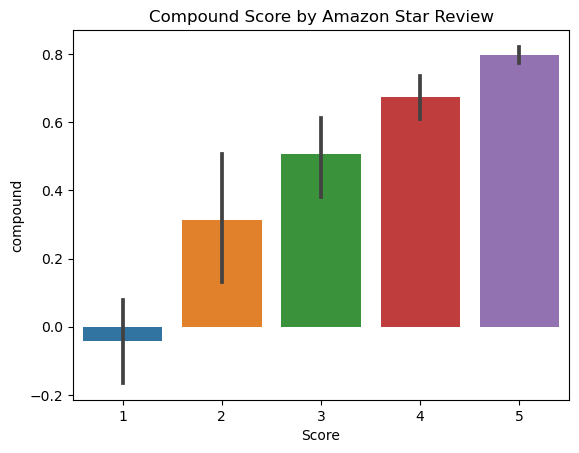

In [123]:
sx = sns.barplot(data=vaders, x='Score', y='compound')
sx.set_title('Compound Score by Amazon Star Review')
plt.show()

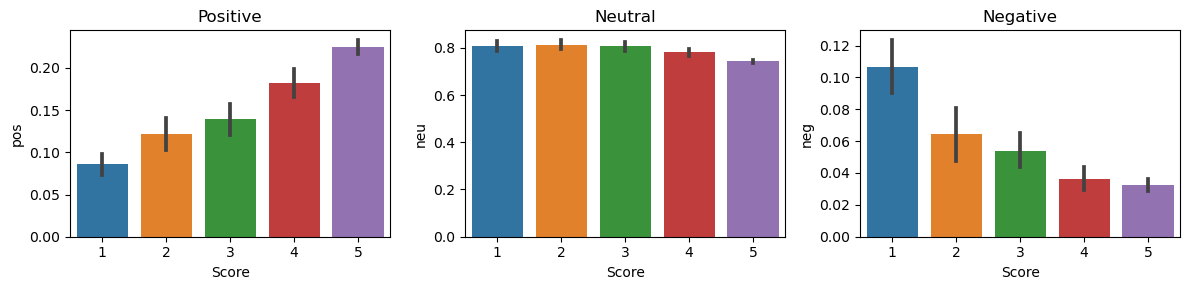

In [124]:
fig, shx = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=shx[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=shx[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=shx[2])
shx[0].set_title('Positive')
shx[1].set_title('Neutral')
shx[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [125]:
pip install transformers[torch]

In [126]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


# Using pretrained Roberta model

In [127]:
 from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax


In [128]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [129]:
example = 'I feel amazing'
sia.polarity_scores(example)


{'neg': 0.0, 'neu': 0.208, 'pos': 0.792, 'compound': 0.5859}

In [130]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.0018303499, 'roberta_neu': 0.017776754, 'roberta_pos': 0.9803929}


In [131]:
#clearly roberta is way better 
#defining some utility functions
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [132]:
res = {}
error_ids = []
for i, row in tqdm(final.iterrows(), total=len(final)):
    try:
        text = row['Text']
        myid = row['Id']
        if isinstance(text, list):
            text = ' '.join(text)
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')
        error_ids.append(myid)

# Remove rows with errors from final_df
final_df = final.loc[~final['Id'].isin(error_ids)]


  0%|          | 0/998 [00:00<?, ?it/s]

Broke for id 10031
Broke for id 14764
Broke for id 50910
Broke for id 136895
Broke for id 140145
Broke for id 149954
Broke for id 213293
Broke for id 259831
Broke for id 328013
Broke for id 441093
Broke for id 476450
Broke for id 487901
Broke for id 510474
Broke for id 511912
Broke for id 539427


In [133]:
final_result = pd.DataFrame(res).T
final_result = final_result.reset_index().rename(columns={'index': 'Id'})
final_result = final_result.merge(final_df, how='left')


In [134]:
final_result


,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,955,0.022,0.836,0.142,0.8623,0.135898,0.367880,0.496223,B000S806VM,A2HF72GRWTRW35,"James H. Walder ""Jim Walder""",3,3,4,1299196800,sassafrass tea,"[I, grew, up, in, Ohio, and, lived, in, the, w..."
1,2290,0.000,0.929,0.071,0.6369,0.003137,0.079194,0.917668,B002MB2J6I,A2D4ODIUEX9ZVY,Necmiye Eren,1,1,5,1289952000,"Delicious, nutrient-packed, fast--","[I, buy, these, through, the, ship-and-save, p..."
2,2743,0.053,0.851,0.096,0.5023,0.029090,0.118782,0.852128,B003NDA970,A1BT7GMP117HQH,Ryan Mahoney,0,0,3,1318204800,Received wrong product,"[Received, the, ``, Baby, Yellow, '', instead,..."
3,3863,0.058,0.913,0.029,-0.3668,0.944939,0.050046,0.005015,B001M074MY,A3E0DOZLYQWUOP,liane douglas,0,0,3,1347580800,just ok,"[Some, issues, with, the, product, --, some, o..."
4,5267,0.000,0.606,0.394,0.8555,0.001032,0.021039,0.977929,B0012YEKCW,A31LXLAA6LADQT,cd,0,0,5,1316908800,Cat Grass,"[This, product, is, great, for, growing, cat, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,566176,0.045,0.782,0.173,0.9862,0.019259,0.120942,0.859799,B004P4POZ8,A3JO7AX04PPPFQ,WisconsinWoman,0,0,5,1328918400,Feeding my sweet-tooth AND shrinking my waistl...,"[I, 'm, not, worried, about, my, fat, intake, ..."
979,566732,0.287,0.540,0.173,-0.4574,0.003466,0.032153,0.964381,B000634EZS,A23755ONHR63P5,Sonora,3,4,5,1220659200,The Best Kitty Litter,"[Affordably, priced, ,, environmentally, frien..."
980,567820,0.000,0.902,0.098,0.9040,0.002089,0.036988,0.960923,B005K4Q68Q,A24C0RPF1TGY7,L. Ketchum,0,1,5,1342915200,"The ""Replicator"" of our time.","[We, have, a, new, hot, beverage, cooker, ., T..."
981,568017,0.000,0.661,0.339,0.8478,0.001643,0.007992,0.990365,B0030VJ8YU,AECQLWLETPUFZ,Tamara Irving,2,2,5,1274572800,perfect portions,"[This, is, a, perfect, portion, and, very, sim..."


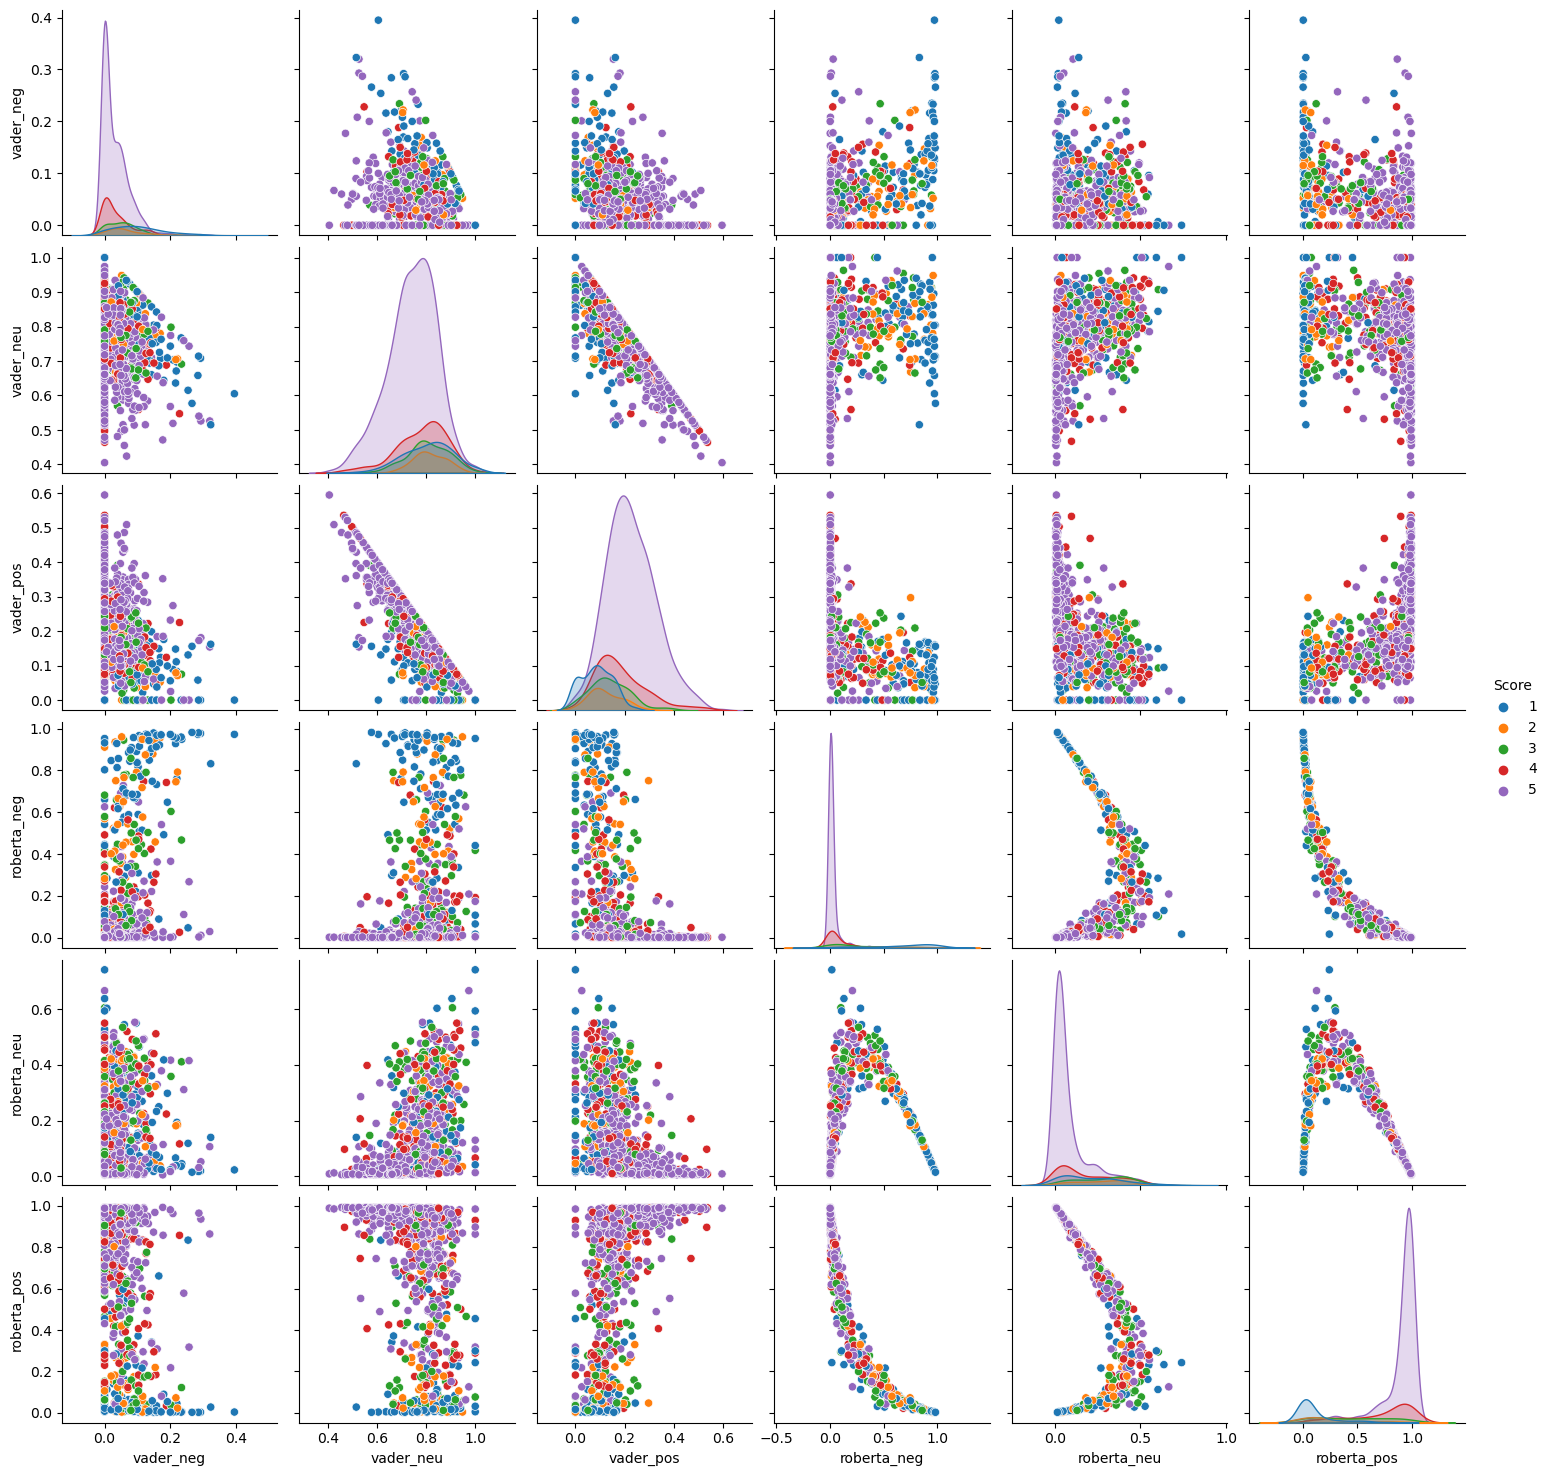

In [135]:
sns.pairplot(data=final_result,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

In [136]:
final_result.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

['the',
 'product',
 'was',
 'very',
 'good',
 '.',
 'why',
 'i',
 'gave',
 'it',
 '1',
 'star',
 'was',
 'the',
 'poor',
 'packaging',
 'and',
 'all',
 'the',
 'broken',
 'cookies',
 '.']

In [137]:
final_result.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

['I',
 'should',
 'have',
 'known',
 'better',
 '...',
 'The',
 'chocolate',
 'came',
 'all',
 'melted',
 '...',
 'Trying',
 'to',
 'save',
 'a',
 'few',
 'pennies',
 'I',
 'end',
 'up',
 'spending',
 'more',
 '...']

In [143]:
final_result.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

['My',
 'hubby',
 'wanted',
 'a',
 'Keurig',
 'because',
 'they',
 'had',
 'the',
 'nice',
 'big',
 'industrial',
 'ones',
 'in',
 'Iraq',
 ',',
 'I',
 'asked',
 'him',
 'who',
 'bought',
 'it',
 ',',
 'he',
 'told',
 'me',
 'that',
 'Keurig',
 'sent',
 'them',
 'a',
 'ton',
 'of',
 'free',
 'Keurigs',
 ',',
 'and',
 'they',
 'sent',
 'them',
 'a',
 'bunch',
 'of',
 'boxes',
 'of',
 'coffee',
 ',',
 'enough',
 'to',
 'cover',
 'hundreds',
 'of',
 'soldiers',
 'at',
 'a',
 'fob',
 'for',
 '2',
 'rotations',
 ',',
 'to',
 'many',
 'fobs',
 '.',
 'With',
 'so',
 'many',
 'crap',
 'companies',
 ',',
 'with',
 'crap',
 'customer',
 'support',
 ',',
 'most',
 'of',
 'them',
 'do',
 "n't",
 'stand',
 'behind',
 'their',
 'own',
 'products',
 ',',
 'and',
 'this',
 'company',
 'does',
 'more',
 'than',
 'that',
 ',',
 'just',
 'thought',
 'this',
 'might',
 'make',
 'a',
 'difference',
 'to',
 'some',
 'people',
 'debating',
 'buying',
 'one',
 'of',
 'these',
 '.']

In [144]:
final_result.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

['My',
 'tomatoes',
 'look',
 'great',
 'this',
 'year',
 ',',
 'not',
 'one',
 'dear',
 'got',
 'past',
 'this',
 'bad',
 'boy',
 '.',
 'Constantly',
 'streaming',
 ',',
 'no',
 'pulse',
 '.']

# creating transformers pipeline

In [138]:
from transformers import pipeline

model_name = "distilbert-base-uncased-finetuned-sst-2-english"
model_revision = "af0f99b"
sent_pipeline = pipeline("sentiment-analysis", model=model_name, revision=model_revision)


In [139]:
sent_pipeline('I love amazon products!')

[{'label': 'POSITIVE', 'score': 0.9997279047966003}]

In [140]:
sent_pipeline('today is a great day to play golf!')

[{'label': 'POSITIVE', 'score': 0.9998536109924316}]

In [141]:
sent_pipeline('booo')

[{'label': 'NEGATIVE', 'score': 0.9936267137527466}]

In [150]:
import pickle
with open('sent_pipeline.pkl', 'wb') as f:
    pickle.dump(sent_pipeline, f)


In [152]:
from joblib import dump

# Train your model here...

# Save your trained model as a file
dump(sent_pipeline, 'sent_pipeline.joblib')


['sent_pipeline.joblib']